In [39]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

%matplotlib inline

In [40]:
data = pd.read_csv('data/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [41]:
address2country = pd.read_csv('data/IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [74]:
merged_data = pd.merge_asof(data.sort_values('ip_address'), 
                            address2country.sort_values('lower_bound_ip_address'), 
                            left_on='ip_address', 
                            right_on='lower_bound_ip_address', 
                            direction='forward', 
                            allow_exact_matches=True)

merged_data.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,original_order,lower_bound_ip_address,upper_bound_ip_address,country
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093.496895,0,110447,16777216.0,16777471.0,Australia
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447.138961,0,2589,16777216.0,16777471.0,Australia
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818.501505,0,16752,16777216.0,16777471.0,Australia
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566.664867,0,51261,16777216.0,16777471.0,Australia
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423.789042,0,17,16777216.0,16777471.0,Australia


#### Feature Engineering

In [119]:
# Get the time difference between purchase time and signup time
# Convert to datetime objects
merged_data['purchase_time'] = pd.to_datetime(merged_data['purchase_time'])
merged_data['signup_time'] = pd.to_datetime(merged_data['signup_time'])

# Calculate the time difference
merged_data['time_difference'] = (merged_data['purchase_time'] - merged_data['signup_time']).dt.total_seconds() / 3600 

# Print the first 5 rows of the updated DataFrame
merged_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,upper_bound_ip_address,country,time_difference,time_difference_minutes,signup_day,signup_week,purchase_day,purchase_week,device_user_counts,ip_user_counts
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093.496895,...,16777471.0,Australia,489.726111,29383.566667,16,8,8,10,1,1
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447.138961,...,16777471.0,Australia,301.339722,18080.383333,8,10,20,12,1,1
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818.501505,...,16777471.0,Australia,208.144444,12488.666667,17,20,26,22,1,1
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566.664867,...,16777471.0,Australia,2065.176111,123910.566667,3,10,28,22,1,1
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423.789042,...,16777471.0,Australia,391.005278,23460.316667,20,12,5,14,1,1


In [101]:
# Group by 'device_id' and count unique 'user_id'
merged_data['device_user_counts'] = merged_data.groupby('device_id')['user_id'].transform('nunique')
# Print the device user counts
print(device_user_counts)

device_id
AAALBGNHHVMKG     1
AAAWIHVCQELTP     1
AAAXJHWCLISKY     1
AAAXXOZJRZRAO    11
AABFGRPBQHWFQ     1
                 ..
ZZZGSIJRNCXBJ     1
ZZZIKLJSVSQMF     1
ZZZKJIZHJEDFN     1
ZZZMVOGBAJVTM     1
ZZZXASJUVUNMV     1
Name: user_id, Length: 137956, dtype: int64


In [102]:
# Group by 'ip_address' and count unique 'user_id'
merged_data['ip_user_counts'] = merged_data.groupby('ip_address')['user_id'].transform('nunique')
# Print the IP user counts
print(ip_user_counts)

ip_address
5.209350e+04    1
9.344714e+04    1
1.058185e+05    1
1.175667e+05    1
1.314238e+05    1
               ..
4.294674e+09    1
4.294715e+09    1
4.294720e+09    1
4.294822e+09    1
4.294850e+09    1
Name: user_id, Length: 143512, dtype: int64


In [120]:
# Signup day and week
merged_data['signup_day'] = merged_data['signup_time'].dt.dayofweek  
merged_data['signup_week'] = merged_data['signup_time'].dt.isocalendar().week
# Purchase day and week
merged_data['purchase_day'] = merged_data['purchase_time'].dt.dayofweek 
merged_data['purchase_week'] = merged_data['purchase_time'].dt.isocalendar().week

# Print the first few rows to verify
print(merged_data[['signup_day', 'signup_week', 'purchase_day', 'purchase_week']].head())

   signup_day  signup_week  purchase_day  purchase_week
0           0            8             6             10
1           6           10             4             12
2           6           20             1             22
3           1           10             3             22
4           4           12             6             14


In [121]:
merged_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,upper_bound_ip_address,country,time_difference,time_difference_minutes,signup_day,signup_week,purchase_day,purchase_week,device_user_counts,ip_user_counts
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093.496895,...,16777471.0,Australia,489.726111,29383.566667,0,8,6,10,1,1
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447.138961,...,16777471.0,Australia,301.339722,18080.383333,6,10,4,12,1,1
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818.501505,...,16777471.0,Australia,208.144444,12488.666667,6,20,1,22,1,1
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566.664867,...,16777471.0,Australia,2065.176111,123910.566667,1,10,3,22,1,1
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423.789042,...,16777471.0,Australia,391.005278,23460.316667,4,12,6,14,1,1


In [122]:
# Define features and target to be used
final_data = merged_data.drop(columns=['signup_time', 'purchase_time', 'device_id', 'ip_address', 'user_id'])
cols_order = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_difference', 'device_user_counts', 'ip_user_counts', 'class']
final_data = final_data[cols_order]

final_data.head()

X = final_data.drop(columns=['class'])
y = final_data['class']


from sklearn.model_selection import train_test_split

# Define the features and target variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test :", y_test.shape)


X_train : (105778, 13)
X_test : (45334, 13)
y_train : (105778,)
y_test : (45334,)


In [112]:
import h2o
import h2o
from sklearn.metrics import auc, roc_curve, classification_report
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from sklearn.model_selection import train_test_split

h2o.init()

# Convert pandas dataframes to H2OFrames
train = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))
predictors = X_train.columns.tolist()
response = 'class'

# Build Random Forest
drf = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10)
drf.train(x=predictors, y=response, training_frame=train)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 mins 26 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_marin_mvojdq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.482 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1693486066851_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          1.88603e+06            20           20           20            1763          3223          2371.8

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.04005245047677347
RMSE: 0.2001310832348975
MAE: 0.07823695933956101
RMSLE: 0.14119492212973322
Mean Residual Deviance: 0.04005245047677347

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.0393830148352231
RMSE: 0.19845154278871985
MAE: 0.07823401732810352
RMSLE: 0.13942430374203946
Mean Residual Deviance: 0.0393830148352231

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.0782349  0.00204042  0.0768347     0.0790494     0.0798288     0.0797643     0.0759167     0.0778344     0.0797099     0.076021      0.0816044     0.0757852
mean_residual_deviance  0.0393826  0.0018384   0.0382738     0.0407776     0.0408458     0.0410145     0.0373635     0.0389871     0.0400703     0.0378289     0.0420994     0.0365653
mse                     0.0393826  0.0018384   0.0382738     0.0407776     0.0408458     0.0410145     0.0373635     0.0389871     0.0400703     0.0378289     0.0420994     0.0365653
r2                      0.533052   0.0122895   0.542766      0.532413      0.529782      0.526419      0.547786      0.52664       0.51519       0.535981      0.519503      0.554039
residual_deviance       0.0393826  0.0018384   0.0382738     0.0407776     0.0408458     0.0410145     0.0373635     0.0389871     0.0400703     0.0378289     0.0420994     0.0365653
rmse                    0.198402   0.00463904  0.195637      0.201935      0.202103      0.20252       0.193297      0.197451      0.200176      0.194497      0.205181      0.191221
rmsle                   0.139393   0.00309665  0.137577      0.141728      0.141793      0.142027      0.13605       0.138512      0.140483      0.136744      0.144236      0.134784

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------
    2023-08-31 14:57:07  6 min 11.373 sec  0                  nan              nan             nan
    2023-08-31 14:57:08  6 min 12.053 sec  1                  0.244091         0.07808         0.0595806
    2023-08-31 14:57:08  6 min 12.481 sec  2                  0.23678          0.0777644       0.0560649
    2023-08-31 14:57:09  6 min 12.944 sec  3                  0.231357         0.0777274       0.0535259
    2023-08-31 14:57:09  6 min 13.488 sec  4                  0.227903         0.0777696       0.0519399
    2023-08-31 14:57:10  6 min 14.067 sec  5                  0.225715         0.0783495       0.0509472
    2023-08-31 14:57:10  6 min 14.636 sec  6                  0.222132         0.0781295       0.0493425
    2023-08-31 14:57:11  6 min 15.276 sec  7                  0.220543         0.0784089       0.048639
    2023-08-31 14:57:16  6 min 19.761 sec  16                 0.206894         0.0781908       0.042805
    2023-08-31 14:57:20  6 min 24.211 sec  26                 0.202943         0.0781839       0.0411859
 

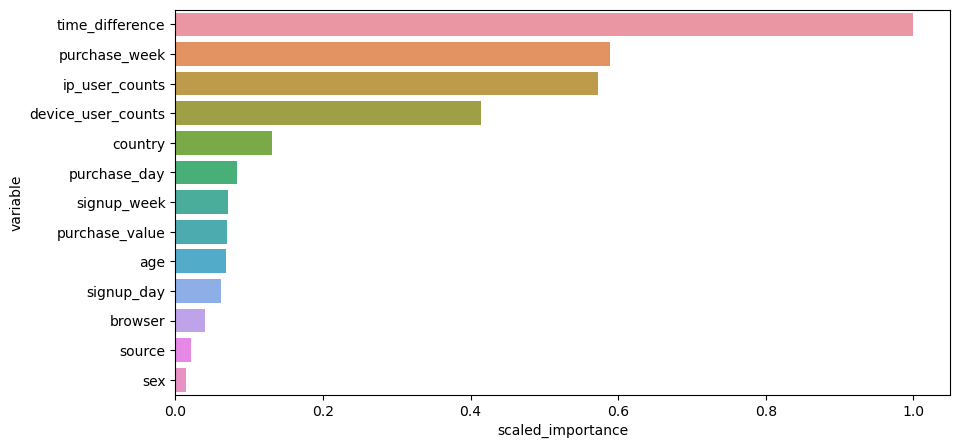

In [124]:
# Feature importance
import matplotlib.pyplot as plt

feature_importances = drf.varimp(use_pandas=True)

plt.figure(figsize=(10, 5))
sns.barplot(x='scaled_importance', y='variable', data=feature_importances.sort_values(by='scaled_importance', ascending=False))
plt.xlabel('scaled_importance')
plt.ylabel('variable')
plt.savefig("Importance.png")

In [132]:
# Classification report
predictions_h2o = drf.predict(test)
predictions_df = predictions_h2o.as_data_frame()
threshold = 0.5 
predictions_df['predict'] = (predictions_df['predict'] > threshold).astype(int)
classification_rep = classification_report(y_test, predictions_df['predict'])
print(classification_rep)


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41017
           1       0.99      0.54      0.70      4317

    accuracy                           0.96     45334
   macro avg       0.97      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



AUC: 0.7694305680889423


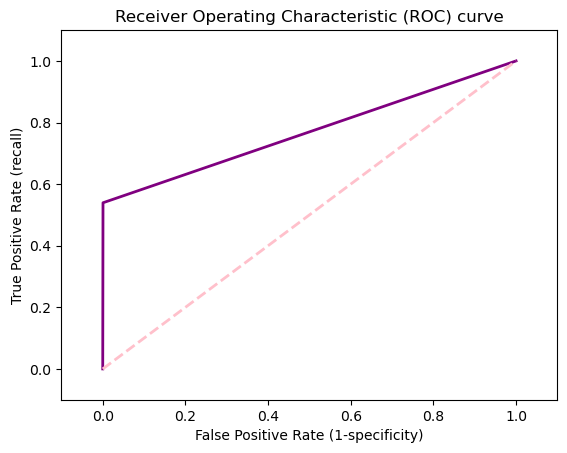

In [147]:
#plot ROC curve and calculate AUC

fpr, tpr, thresholds = roc_curve(y_test, predictions_df['predict'])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='purple', lw=2,)
plt.plot([0, 1], [0, 1], color='pink', lw=2, linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate (1-specificity)')
plt.ylabel('True Positive Rate (recall)')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.savefig("ROC_curve.png")

print("AUC:", roc_auc)